# PUBG 생존자 예측 모델링

## 데이터 설명

File descriptions
- train_V2.csv - the training set 
- test_V2.csv - the test set 
- sample_submission_V2.csv - a sample submission file in the correct format


Data fields

- DBNOs - (적을 기절시켰으나, 적 팀원에 의해 부활되어 실제로는 킬로 처리되지 않은 횟수)
- assists - (어시스트 수)
- boosts - (사용된 부스트 아이템 수)
- damageDealt - (가한 총 피해량 - 자기자신에게 가한 데미지는 제외)
- headshotKills - ( 헤드샷으로 사망한 적 플레이어의 수)
- heals - (사용된 치유 아이템 수)
- Id -         (플레이어 아이디)
- killPlace - (경기에서 처치한 적의 수 랭킹)
- killPoints - (플레이어 처치 기반 외부 랭킹(Elo 방식), rankpoint에서 -1이 아닌 값이 있는 경우, killpoints에서 0은 '없음'으로 처리되어야 한다)
- killStreaks - (짧은 시간에 죽인 적 플레이어의 최대 수)
- kills - (죽인 적 플레이어의 수)
- longestKill - (사망 시 사망한 플레이어와 플레이어 사이의 최장거리. 플레이어를 죽이고 차를 몰고 가면 가장 긴 킬 통계가 나올 수 있으므로 오해의 소지가 있음)
- matchDuration -  (일치 시간(초))
- matchId -  (일치를 식별하는 아이디)
- matchType -  (게임모드:솔로,듀오,스쿼드 등등)
- rankPoints - (플레이어의 Elo와 같은 순위 - 다음 API 버전에서는 삭제될 예정 -1 값은 '없음'을 대신함)
- revives - (소생시킨 횟수)
- rideDistance -  (미터 단위의 차량의 총 이동거리)
- roadKills -  (차량으로 죽인 횟수)
- swimDistance - (미터 단위의 수영 거리)
- teamKills -  (팀원 킬 수)
- vehicleDestroys -  (차량을 폭발시킨 횟수)
- walkDistance -  (미터 단위 총 도보 거리)
- weaponsAcquired -  (획득한 무기의 수)
- winPoints - (플레이어의 승리 기반 외부 랭킹(Elo 방식의 순위). rankpoint에서 -1이 아닌 값이 있는 경우, winpoints에서 0은 '없음'으로 처리)
- groupId -  (경기 내의 그룹을 식별하는 ID. 현재 그룹의 선수들이 다른 경기를 한다면 다른 ID를 갖게됨)
- numGroups - (경기에 있는 그룹의 수)
- maxPlace - (경기에서 가장 순위가 낮은 것에 대한 데이터. 순위를 건너뛸 수 있기에 numgroups와 일치하지 않을 수 있음)
- **winPlacePerc** - (예측 대상. 백분위수 승리 배치로 1은 1위, 0은 경기에서 꼴지했다는것. 이건 numgroups로 계산되는게 아니라, maxPlace로 계산되기 때문에 누락되는 것이 있을 수도 있음)

## Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore')
from collections import Counter
from pprint import pprint
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import lightgbm as lgb

## data

In [2]:
train = pd.read_csv('./pubg-finish-placement-prediction/train_V2.csv')
test = pd.read_csv('./pubg-finish-placement-prediction/test_V2.csv')


In [3]:
# # Memory saving function credit to https: // www.kaggle.com/gemartin/load-data-reduce-memory-usage


# def reduce_mem_usage(df):
#     """ iterate through all the columns of a dataframe and modify the data type
#         to reduce memory usage.        
#     """
#     #start_mem = df.memory_usage().sum() / 1024**2
#     #print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

#     for col in df.columns:
#         col_type = df[col].dtype

#         if col_type != object:
#             c_min = df[col].min()
#             c_max = df[col].max()
#             if str(col_type)[:3] == 'int':
#                 if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
#                     df[col] = df[col].astype(np.int8)
#                 elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
#                     df[col] = df[col].astype(np.int16)
#                 elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
#                     df[col] = df[col].astype(np.int32)
#                 elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
#                     df[col] = df[col].astype(np.int64)
#             else:
#                 if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
#                     df[col] = df[col].astype(np.float16)
#                 elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
#                     df[col] = df[col].astype(np.float32)
#                 else:
#                     df[col] = df[col].astype(np.float64)

#     #end_mem = df.memory_usage().sum() / 1024**2
#     #print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
#     #print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

#     return df


# train = reduce_mem_usage(train)
# test = reduce_mem_usage(test)


In [4]:
train.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


In [5]:
test.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints
0,9329eb41e215eb,676b23c24e70d6,45b576ab7daa7f,0,0,51.46,0,0,0,73,...,1500,0,0.0,0,0.0,0,0,588.0,1,0
1,639bd0dcd7bda8,430933124148dd,42a9a0b906c928,0,4,179.10,0,0,2,11,...,1503,2,4669.0,0,0.0,0,0,2017.0,6,0
2,63d5c8ef8dfe91,0b45f5db20ba99,87e7e4477a048e,1,0,23.40,0,0,4,49,...,1565,0,0.0,0,0.0,0,0,787.8,4,0
3,cf5b81422591d1,b7497dbdc77f4a,1b9a94f1af67f1,0,0,65.52,0,0,0,54,...,1465,0,0.0,0,0.0,0,0,1812.0,3,0
4,ee6a295187ba21,6604ce20a1d230,40754a93016066,0,4,330.20,1,2,1,7,...,1480,1,0.0,0,0.0,0,0,2963.0,4,0


In [6]:
train.shape, test.shape

((4446966, 29), (1934174, 28))

In [7]:
# null 값 확인
train.isnull().sum()

Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
winPlacePerc       1
dtype: int64

- winPlacePerc 하나가 누락된 것을 확인

In [8]:
train[train['winPlacePerc'].isnull()]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
2744604,f70c74418bb064,12dfbede33f92b,224a123c53e008,0,0,0.0,0,0,0,1,...,0,0.0,0,0.0,0,0,0.0,0,0,NaN


In [9]:
# winPlacePerc가 결측치인 2744604번을 drop
train.drop(2744604, inplace=True)

In [10]:
train.isnull().sum()

Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
winPlacePerc       0
dtype: int64

In [11]:
test.isnull().sum()


Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
dtype: int64

In [12]:
train.columns

Index(['Id', 'groupId', 'matchId', 'assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
       'killStreaks', 'longestKill', 'matchDuration', 'matchType', 'maxPlace',
       'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills',
       'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance',
       'weaponsAcquired', 'winPoints', 'winPlacePerc'],
      dtype='object')

In [13]:
train.headshotKills.value_counts()

0     3696115
1      574741
2      126348
3       32975
4        9962
5        3616
6        1439
7         757
8         373
9         215
10        136
11         79
12         64
13         44
14         23
15         16
16         15
17         11
18          9
19          3
20          3
23          3
26          3
21          2
27          2
31          2
34          2
35          1
39          1
40          1
41          1
42          1
46          1
64          1
Name: headshotKills, dtype: int64

In [14]:
# 거리 합치기
train['total_Dist'] = train['rideDistance'] + train['swimDistance'] + train['walkDistance']

In [15]:
test['total_Dist'] = test['rideDistance'] + test['swimDistance'] + test['walkDistance']

In [16]:
# kill, assist 합치기
train['kills_with_assist'] = train['kills'] + train['assists']
test['kills_with_assist'] = test['kills'] + test['assists']

In [17]:
# heals + boosts
train['recovery'] = train['heals'] + train['boosts']
test['recovery'] = test['heals'] + test['boosts']


In [18]:
train['total_Dist'].mean()

1764.8432475661932

<AxesSubplot:>

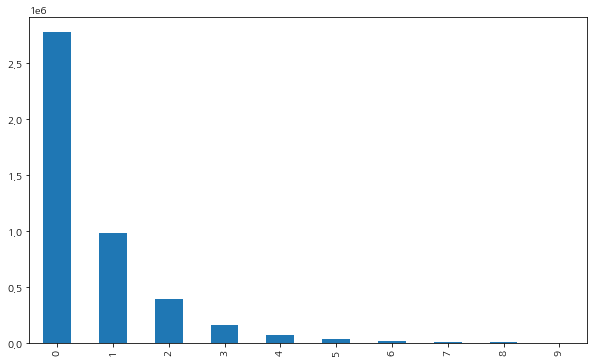

In [19]:
# n = 20
# data = np.random.normal(loc=0, size=n, scale=500000) + 1000000

fig = plt.figure(figsize=(10, 6))
train.DBNOs.value_counts().head(10).plot(kind='bar')

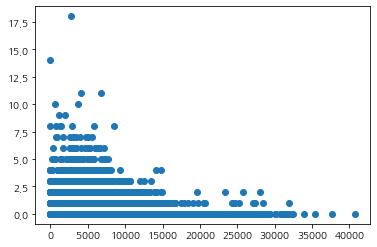

In [20]:
plt.scatter(train['rideDistance'], train['roadKills'])

In [21]:
train['headshot_over_kills'] = train['headshotKills'] / train['kills']
train['headshot_over_kills'].fillna(0, inplace=True)


In [22]:
test['headshot_over_kills'] = test['headshotKills'] / test['kills']
test['headshot_over_kills'].fillna(0, inplace=True)


In [23]:
train['headshot_over_kills'].value_counts().head(5)

0.000000    3696115
1.000000     254068
0.500000     196009
0.333333     104061
0.250000      53362
Name: headshot_over_kills, dtype: int64

In [24]:
train = train.drop(['Id','groupId','matchId', 'killPlace'],axis=1)

In [25]:
train.shape

(4446965, 29)

In [26]:
# matchType 고유값
matchType = train.matchType.unique()

In [27]:
len(matchType)

16

In [28]:
match_dict = {}
for i, each in enumerate(matchType):
    match_dict[each] = i


In [29]:
match_dict

{'squad-fpp': 0,
 'duo': 1,
 'solo-fpp': 2,
 'squad': 3,
 'duo-fpp': 4,
 'solo': 5,
 'normal-squad-fpp': 6,
 'crashfpp': 7,
 'flaretpp': 8,
 'normal-solo-fpp': 9,
 'flarefpp': 10,
 'normal-duo-fpp': 11,
 'normal-duo': 12,
 'normal-squad': 13,
 'crashtpp': 14,
 'normal-solo': 15}

In [30]:
train.matchType = train.matchType.map(match_dict)

In [31]:
matchtype_test = test.matchType.unique()
match_dict_test = {}
for i, each in enumerate(matchtype_test):
    match_dict_test[each] = i
test.matchType = test.matchType.map(match_dict_test)


In [32]:
y = train['winPlacePerc']

In [33]:
X = train.drop(['winPlacePerc'], axis=1)

In [34]:
X.shape, y.shape

((4446965, 28), (4446965,))

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [36]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3112875, 28), (1334090, 28), (3112875,), (1334090,))

In [37]:
scaler = StandardScaler()
X_train_scaler = scaler.fit_transform(X_train)
X_test_scaler = scaler.transform(X_test)

### Linear Regression

In [38]:
linear = LinearRegression()
linear.fit(X_train_scaler, y_train)

LinearRegression()

In [39]:
y_pred = linear.predict(X_test_scaler)

In [40]:
y_pred

array([0.55013887, 0.84645101, 1.04769662, ..., 0.84256715, 0.29347997,
       0.40815692])

In [41]:
rmse = sqrt(mean_squared_error(y_test, y_pred))
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test,y_pred)

In [42]:
print('RMSE:', rmse)
print('MSE:', mse)
print('R Squared:', r2)

RMSE: 0.1524811235253009
MSE: 0.023250493031538075
R Squared: 0.7537302628728775


In [43]:
res = pd.DataFrame()
res['Actual'] = y_test
res['Predicted'] = y_pred
res['Difference'] = abs(y_test-y_pred)


In [44]:
res.head()

,Actual,Predicted,Difference
4270780,0.2800,0.550139,0.270139
1687951,0.8571,0.846451,0.010649
3732583,0.7812,1.047697,0.266497
3386217,0.1379,0.218146,0.080246
243580,0.7263,0.657227,0.069073


### Decision Tree Regressor

In [45]:
dtr = DecisionTreeRegressor()
dtr.fit(X_train_scaler, y_train)

DecisionTreeRegressor()

In [46]:
y_pred_dtr = dtr.predict(X_test_scaler)

In [47]:
rmse = sqrt(mean_squared_error(y_test, y_pred_dtr))
mse = mean_squared_error(y_test, y_pred_dtr)
r2 = r2_score(y_test,y_pred_dtr)

In [48]:
print('RMSE:', rmse)
print('MSE:', mse)
print('R Squared:', r2)

RMSE: 0.18353619131594
MSE: 0.03368553352276134
R Squared: 0.6432020828812279


In [49]:
dtr = pd.DataFrame()
dtr['Actual'] = y_test
dtr['Predicted'] = y_pred_dtr
dtr['Difference'] = abs(y_test-y_pred_dtr)


In [50]:
dtr.head()

,Actual,Predicted,Difference
4270780,0.2800,1.0000,0.7200
1687951,0.8571,0.9158,0.0587
3732583,0.7812,0.9341,0.1529
3386217,0.1379,0.0345,0.1034
243580,0.7263,0.7812,0.0549


### LightGBM

In [51]:
parameters = {
    'max_depth': 1, 'min_data_in_leaf': 85, 'feature_fraction': 0.80, 'bagging_fraction': 0.8, 'boosting_type': 'gbdt',
    'learning_rate': 0.1, 'num_leaves': 30, 'subsample': 0.8, 'lambda_l2': 4, 'objective': 'regression_l2',
    'application': 'regression', 'num_boost_round': 5000, 'zero_as_missing': True,
    'early_stopping_rounds': 100, 'metric': 'mae', 'seed': 2
}


In [52]:
train_data = lgb.Dataset(X_train_scaler, y_train, silent=False)
test_data = lgb.Dataset(X_test_scaler, y_test, silent=False)
model = lgb.train(parameters, train_set = train_data,verbose_eval=500, valid_sets=test_data)

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.8 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] objective is set=regression_l2, application=regression will be ignored. Current value: objective=regression_l2
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.8 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] objective is set=regression_l2, application=regression will be ignored. Current value: objective=regression_l2
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.487916 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3118
[LightGBM] [Info] Number of data points in the train set: 3112875, number of used features: 28
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.8 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] object

In [53]:
test = test.drop(['Id', 'groupId', 'matchId', 'killPlace'], axis=1)

In [54]:
pred_lgb_samp_scaler = model.predict(X_test_scaler, num_iteration=model.best_iteration)

In [55]:
lgb_res = pd.DataFrame()
lgb_res['Actual'] = y_test
lgb_res['Predicted_sc'] = pred_lgb_samp_scaler
lgb_res['Difference'] = abs(y_test-pred_lgb_samp_scaler)

In [56]:
lgb_res.head()

,Actual,Predicted_sc,Difference
4270780,0.2800,0.620340,0.340340
1687951,0.8571,0.875380,0.018280
3732583,0.7812,0.904845,0.123645
3386217,0.1379,0.170297,0.032397
243580,0.7263,0.729260,0.002960


In [57]:
scaler_test = StandardScaler()
test_scaler = scaler_test.fit_transform(test)

In [58]:
pred_lgb_scaler = model.predict(test_scaler, num_iteration=model.best_iteration)

In [59]:
pred_lgb_scaler

array([0.23996572, 0.86563397, 0.3843525 , ..., 0.79973299, 0.80864436,
       0.04973846])

In [60]:
pred_lgb_scaler[pred_lgb_scaler > 1] = 1
pred_lgb_scaler[pred_lgb_scaler < 0] = 0

In [61]:
len(pred_lgb_scaler)

1934174

In [63]:
sample_submission = pd.read_csv('./pubg-finish-placement-prediction/sample_submission_V2.csv')


In [64]:
sample_submission['winPlacePerc'] = pred_lgb_scaler

In [65]:
sample_submission.to_csv('sample_submission.csv',index=False)

In [ ]:
Score: 0.09536